# Contents

- xx
- xx
- xx

# Install libaries

In [5]:
!pip install pydicom -q
!pip uninstall torch torchvision -y
!pip install torch==2.1 torchvision==0.16 -q
!pip install -qU pycocotools
!pip install -qU wandb

# Configs

In [6]:
for name in list(globals()):
    if not name.startswith("_"):  # Avoid deleting built-in and special variables
        del globals()[name]

In [7]:
CONDITION = 'SpinalCanalStenosis'

## Install and load libraries

In [8]:
import os
import time
import random
from datetime import datetime
import numpy as np
import collections

from matplotlib import animation, rc
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt

import tqdm
import sys
import torch

## Reproducibility

In [9]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

## Directories

In [10]:
# Directories
PROJECT_DIR = '/home/jupyter'
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
SRC_DIR = os.path.join(PROJECT_DIR, 'src')
CROP_DIR = os.path.join(DATA_DIR, 'train_crops', '02_train_disc_detection', CONDITION)
os.makedirs(CROP_DIR, exist_ok=True)
MODEL_DIR = os.path.join(PROJECT_DIR, 'models', '02_train_disc_detection', CONDITION)
os.makedirs(MODEL_DIR, exist_ok=True)

## Functions

In [11]:
with open(os.path.join(SRC_DIR, 'pipeline_disc_detection.py')) as file:
    exec(file.read())

## Hyperparameters

In [12]:
CONFIG = dict(
    num_epochs=3,
    batch_size=10,
    lr=0.0001,
    lr_step_size=3,
    lr_gamma=0.1,
    box_w = 70, # width of the bounding boxes
    box_h_l1_l4 = 30, # height of the boxes for levels from L1/L2 to L4/L5
    box_h_l5 = 40 # width of the boxes for level L5/S1
)

## Metadata

In [13]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'processed_metadata', CONDITION, 'val.csv'))

## Example of bounding boxes

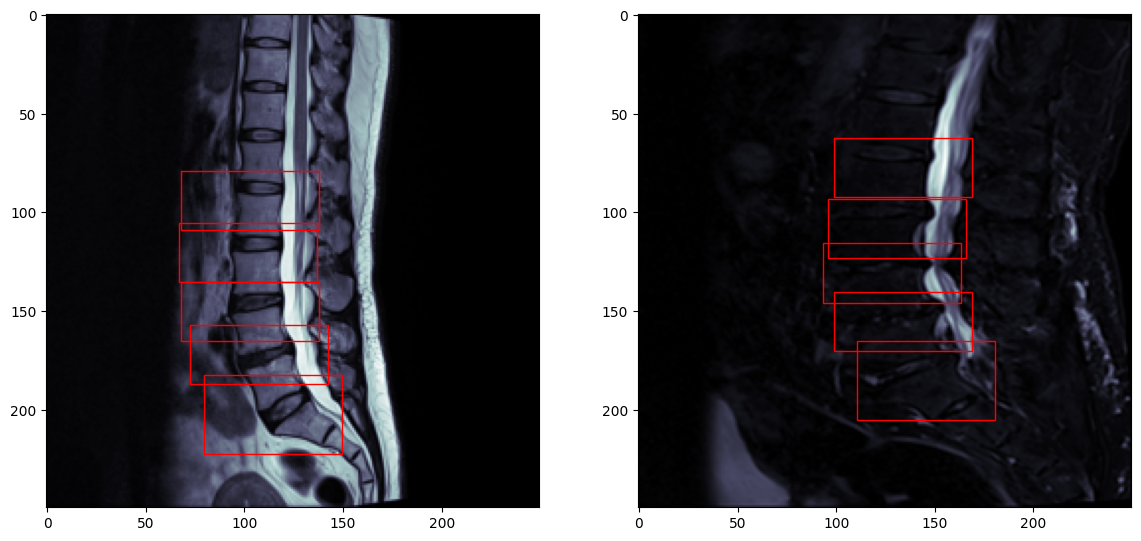

In [10]:
tmp_ds = RSNAMultipleBBoxesDataset(train_df, w = CONFIG['box_w'], h_l1_l4 = CONFIG['box_h_l1_l4'], h_l5 = CONFIG['box_h_l5'])
tmp_dl = torch.utils.data.DataLoader(
  tmp_ds,
  batch_size=1,
  shuffle=False,
  collate_fn=utils.collate_fn
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,16))
for i, (img, target) in enumerate(tmp_dl):
    if i == 2: break
    img = img[0]
    target = target[0]
    y = img.squeeze().numpy()
    ax[i].imshow(y, cmap=plt.cm.bone)
    for j, box in enumerate(target['boxes']):
        x0, y0, x1, y1 = box.numpy()
        w = x1 - x0
        h = y1 - y0
        ax[i].add_patch(patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none'))
del tmp_ds, tmp_dl

# Training

## Load model

In [11]:
model = load_model_disc_detection()

In [12]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the model: {count_trainable_parameters(model)}")

Number of trainable parameters in the model: 43051309


## Test forward pass

In [13]:
# Create dataset and dataloader
dataset = RSNAMultipleBBoxesDataset(train_df, w = CONFIG['box_w'], h_l1_l4 = CONFIG['box_h_l1_l4'], h_l5 = CONFIG['box_h_l5'])
train_loader = torch.utils.data.DataLoader(
  dataset,
  batch_size=2,
  shuffle=True,
  collate_fn=utils.collate_fn
)

# Get first input from dataloader
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

# Inference
model.to('cpu')
model.eval()
with torch.inference_mode():
    predictions = model(images)
    
# Inspect output
print(f"Keys in the prediction: {predictions[0].keys()}")
print(f"Shape of the predicted 'boxes' object: {predictions[0]['boxes'].shape}")  # [100 boxes, 4 dim (x0, y0, x1, y1)]
print(f"Coordinates of the first box: {torch.round(predictions[0]['boxes'][0]).tolist()}") # (x0, y0, x1, y1) of the first box
print(f"Label predictions of the first 5 boxes: {predictions[0]['labels'][:5]}")
print(f"Prediction scores of the first 5 boxes: {predictions[0]['scores'][:5]}") 

Keys in the prediction: dict_keys(['boxes', 'labels', 'scores'])
Shape of the predicted 'boxes' object: torch.Size([100, 4])
Coordinates of the first box: [154.0, 12.0, 154.0, 144.0]
Label predictions of the first 5 boxes: tensor([2, 2, 2, 2, 2])
Prediction scores of the first 5 boxes: tensor([0.9989, 0.9987, 0.9978, 0.9969, 0.9960])


## Train and validate

In [14]:
# torch.cuda.empty_cache()
# gc.collect()

In [15]:
model_pipeline(config=CONFIG, model=model, model_dir=MODEL_DIR, train_df=train_df, val_df=val_df)

Training Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: [0]  [  0/181]  eta: 0:17:47  lr: 0.000001  loss: 2.5494 (2.5494)  loss_classifier: 1.9090 (1.9090)  loss_box_reg: 0.0856 (0.0856)  loss_objectness: 0.5266 (0.5266)  loss_rpn_box_reg: 0.0281 (0.0281)  time: 5.8994  data: 1.4319  max mem: 12823
Epoch: [0]  [ 30/181]  eta: 0:07:02  lr: 0.000017  loss: 1.3473 (1.8017)  loss_classifier: 0.8785 (1.2590)  loss_box_reg: 0.3822 (0.2954)  loss_objectness: 0.0557 (0.2168)  loss_rpn_box_reg: 0.0310 (0.0306)  time: 2.7444  data: 0.0317  max mem: 13169
Epoch: [0]  [ 60/181]  eta: 0:05:51  lr: 0.000034  loss: 0.7892 (1.3414)  loss_classifier: 0.3396 (0.8345)  loss_box_reg: 0.4295 (0.3655)  loss_objectness: 0.0115 (0.1188)  loss_rpn_box_reg: 0.0122 (0.0226)  time: 3.0786  data: 0.0334  max mem: 13169
Epoch: [0]  [ 90/181]  eta: 0:04:28  lr: 0.000051  loss: 0.4792 (1.0685)  loss_classifier: 0.2212 (0.6354)  loss_box_reg: 0.2359 (0.3346)  loss_objectness: 0.0035 (0.0817)  loss_rpn_box_reg: 0.0041 (0.0167)  time: 3.0728  data: 0.0339  max mem: 13

Training Epochs:  33%|███▎      | 1/3 [10:26<20:52, 626.48s/it]

Epoch: [1]  [  0/181]  eta: 0:11:51  lr: 0.000100  loss: 0.1644 (0.1644)  loss_classifier: 0.0647 (0.0647)  loss_box_reg: 0.0967 (0.0967)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 3.9328  data: 0.8869  max mem: 13169
Epoch: [1]  [ 30/181]  eta: 0:07:46  lr: 0.000100  loss: 0.1509 (0.1533)  loss_classifier: 0.0631 (0.0692)  loss_box_reg: 0.0783 (0.0813)  loss_objectness: 0.0004 (0.0013)  loss_rpn_box_reg: 0.0013 (0.0015)  time: 3.0681  data: 0.0318  max mem: 13169
Epoch: [1]  [ 60/181]  eta: 0:06:12  lr: 0.000100  loss: 0.1436 (0.1512)  loss_classifier: 0.0574 (0.0668)  loss_box_reg: 0.0819 (0.0821)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0011 (0.0013)  time: 3.0722  data: 0.0356  max mem: 13169
Epoch: [1]  [ 90/181]  eta: 0:04:39  lr: 0.000100  loss: 0.1306 (0.1463)  loss_classifier: 0.0536 (0.0641)  loss_box_reg: 0.0743 (0.0801)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0011 (0.0013)  time: 3.0668  data: 0.0355  max mem: 13

Training Epochs:  67%|██████▋   | 2/3 [20:39<10:18, 618.39s/it]

Epoch: [2]  [  0/181]  eta: 0:11:45  lr: 0.000100  loss: 0.0993 (0.0993)  loss_classifier: 0.0360 (0.0360)  loss_box_reg: 0.0618 (0.0618)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0013 (0.0013)  time: 3.8987  data: 0.8885  max mem: 13169
Epoch: [2]  [ 30/181]  eta: 0:07:45  lr: 0.000100  loss: 0.0866 (0.0852)  loss_classifier: 0.0290 (0.0310)  loss_box_reg: 0.0547 (0.0529)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 3.0679  data: 0.0351  max mem: 13169
Epoch: [2]  [ 60/181]  eta: 0:06:12  lr: 0.000100  loss: 0.0949 (0.0892)  loss_classifier: 0.0327 (0.0329)  loss_box_reg: 0.0582 (0.0549)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 3.0679  data: 0.0347  max mem: 13169
Epoch: [2]  [ 90/181]  eta: 0:04:39  lr: 0.000100  loss: 0.0804 (0.0882)  loss_classifier: 0.0299 (0.0323)  loss_box_reg: 0.0525 (0.0546)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0007 (0.0008)  time: 3.0721  data: 0.0346  max mem: 13

Training Epochs: 100%|██████████| 3/3 [30:51<00:00, 617.02s/it]


<div style="font-size: 16px;"><strong>
    CONCLUSION: We pick the model generated by 2nd epoch (i.e., epoch 1) because it has the best validation accuracy!
</strong></div>

# Check out examples of predictions

In [14]:
trained_model = load_model_disc_detection(state_dict=torch.load(os.path.join(f"{MODEL_DIR}/epoch_1/model_dict.pt")))

In [15]:
LABELS_DICT = {
    1: "L1_L2",
    2: "L2_L3",
    3: "L3_L4",
    4: "L4_L5",
    5: "L5_S1"
}

In [16]:
def get_best_boxes(pred):
    best_boxes = {}

    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
        if label.item() not in best_boxes or score > best_boxes[label.item()]['score']:
            best_boxes[label.item()] = {'box': box.tolist(), 'score': score.item()}

    result = {
        'boxes': [entry['box'] for entry in best_boxes.values()],
        'labels': list(best_boxes.keys()),
        'scores': [entry['score'] for entry in best_boxes.values()]
    }

    return result

def plot_prediction(x, pred):
    x = x[0, :]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
    ax.imshow(x, cmap="bone")
    pred = get_best_boxes(pred)
    for i in range(len(pred['boxes'])):
        x0, y0, x1, y1 = pred['boxes'][i]
        label = pred['labels'][i]
        score = pred['scores'][i]
        h = y1 - y0
        w = x1 - x0
        ax.add_patch(patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none'))
        ax.text(x0+w+10, y0+h/2, f"{LABELS_DICT[label]} ({'{:.2f}'.format(score)})", color='r',fontsize=14)

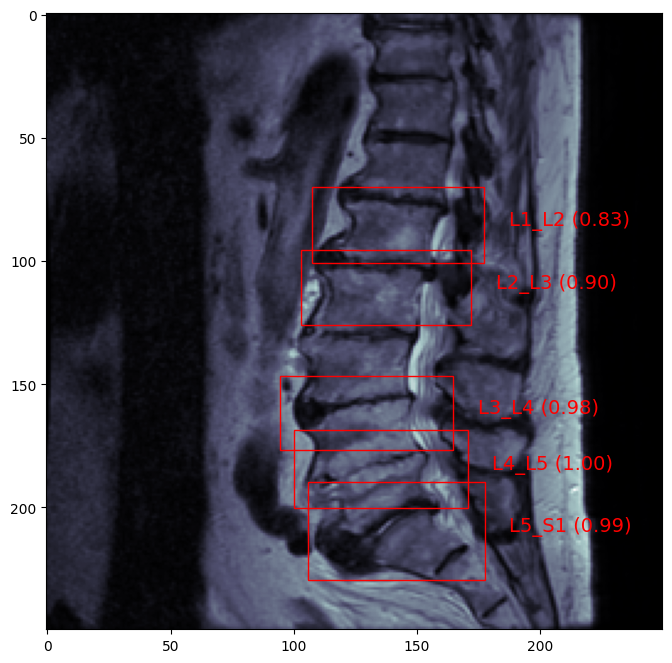

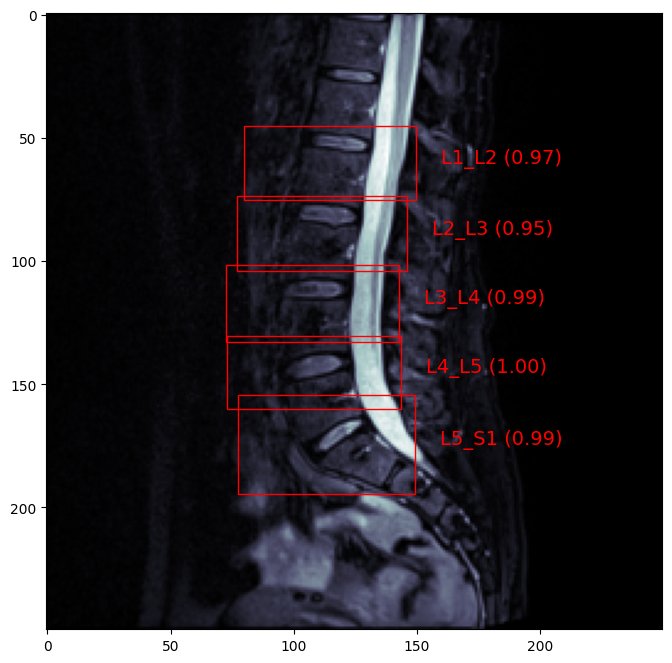

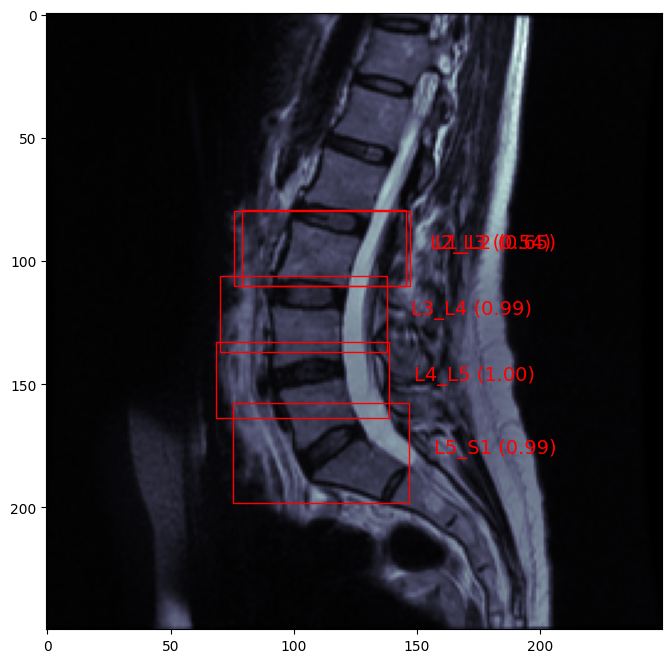

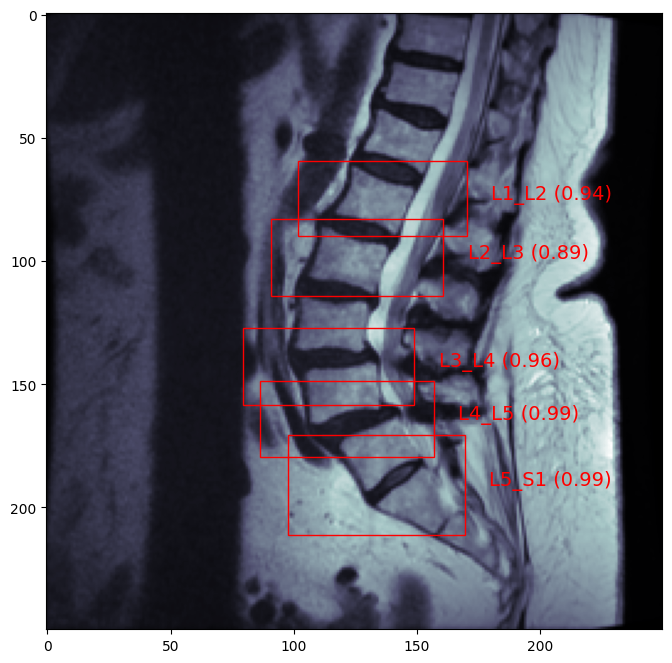

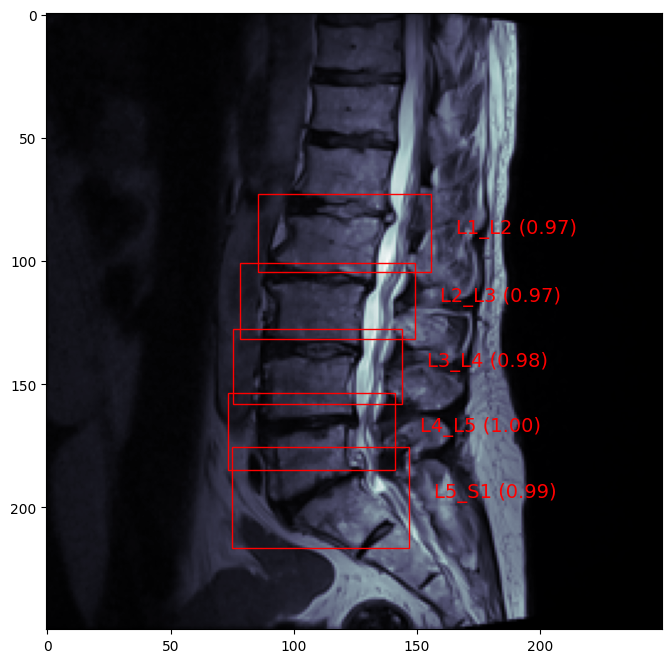

In [17]:
# Plot predictions for a few validation samples
dataset_val = RSNAMultipleBBoxesDataset(val_df, w = CONFIG['box_w'], h_l1_l4 = CONFIG['box_h_l1_l4'], h_l5 = CONFIG['box_h_l5'])
val_loader = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=True,
    collate_fn=utils.collate_fn,
    num_workers=os.cpu_count()
)

for i, (images, targets) in enumerate(val_loader):
    if i == 5: break
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

    trained_model.to(device)
    trained_model.eval()
    with torch.inference_mode():
        predictions = trained_model(images)

    for i in range(len(images)):
        plot_prediction(images[i].cpu(), predictions[i])

# Crop Image with True Labels and Save

<div style="font-size: 16px;">
    In this section, we crop the images in training and validation set using <strong>true</strong> labels and save them for future use.
</div>

In [ ]:
def get_true_boxes(target):

    result = {
        'boxes': target['boxes'].tolist(),
        'labels': target['labels'].tolist()
    }

    return result

def crop_bbox(image, bbox):
    x0, y0, x1, y1 = bbox

    cropped_img = torchvision.transforms.functional.crop(
        image,
        top=round(int(y0)),
        left=round(int(x0)),
        height=round(int(y1 - y0)),
        width=round(int(x1 - x0))
    )
    return cropped_img


def plot_crop(image, bboxes):
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(4,3))
    plt.subplots_adjust(top=2)

    for i in range(len(bboxes['boxes'])):
        label_i = bboxes['labels'][i] - 1
        label = LABELS_DICT[label_i + 1]
        score = bboxes['scores'][i]
        bbox = bboxes['boxes'][i]

        cropped_img = crop_bbox(image, bbox)
        cropped_img = cropped_img[0, :]
        # print(cropped_img.shape)

        ax[label_i].set_axis_off()
        ax[label_i].imshow(cropped_img, cmap="bone")
        ax[label_i].set_title(f"{label} ({'{:.2f}'.format(score)})")
        

def save_crop(image, bboxes, target):
    series_id = target['series_id']
    study_id = target['study_id']
    instance_number = target['instance_number']

    for i in range(len(bboxes['boxes'])):
        label = LABELS_DICT[bboxes['labels'][i]]

        dirname = f'{CROP_DIR}/{study_id}/{series_id}/{label}'
        os.makedirs(dirname, exist_ok=True)
        filepath = os.path.join(dirname, f'{instance_number}.pt')

        bbox = bboxes['boxes'][i]

        cropped_img = crop_bbox(image, bbox)
        torch.save(cropped_img, filepath)

    return

In [ ]:
def crop_and_save_true_boxes(df, limit = None):
    
    dataset = RSNAMultipleBBoxesDataset(df, w = CONFIG['box_w'], h_l1_l4 = CONFIG['box_h_l1_l4'], h_l5 = CONFIG['box_h_l5'], limit=limit)
    train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=10,
        shuffle=True,
        collate_fn=utils.collate_fn
    )

    for i, (images, targets) in enumerate(tqdm.tqdm(train_loader)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

        for i in range(len(images)):
            bboxes = get_true_boxes(targets[i])
            save_crop(images[i].cpu(), bboxes, targets[i])

In [ ]:
crop_and_save_true_boxes(df = train_df, limit = None)

In [ ]:
crop_and_save_true_boxes(df = val_df, limit = None)

## Check out a few crops with different conditions

In [24]:
def load_crop(row, plot=True, title=None, output=True):
    file = f"{CROP_DIR}/{row['study_id']}/{row['series_id']}/{LABELS_DICT[row['level_code']]}/{row['instance_number']}.pt"
    crop = torch.load(file).squeeze(0)
    if plot:
        plt.imshow(crop, cmap="bone")
        if title: plt.title(title)
        plt.show()
    if output:
        return crop

In [25]:
x = load_crop(train_df.iloc[0], plot=False, output=True)
trans = T.ToDtype(torch.float, scale=True)
y = trans(x)

### L1/L2 crops

In [26]:
train_df[train_df.level_code == 1].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,/home/jupyter/data/train_images/4003253/702807...,1,0
185,105895264,Spinal Canal Stenosis,L1/L2,Severe,1073066831,12,243.470958,117.852433,Sagittal T2/STIR,/home/jupyter/data/train_images/105895264/1073...,1,2
350,215111925,Spinal Canal Stenosis,L1/L2,Moderate,1430421856,10,231.135431,120.820793,Sagittal T2/STIR,/home/jupyter/data/train_images/215111925/1430...,1,1


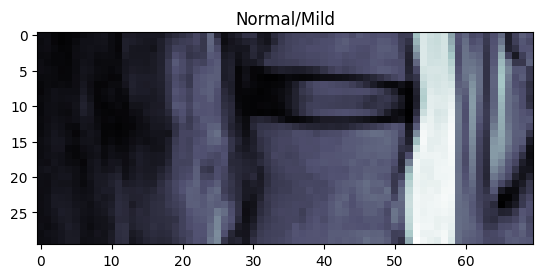

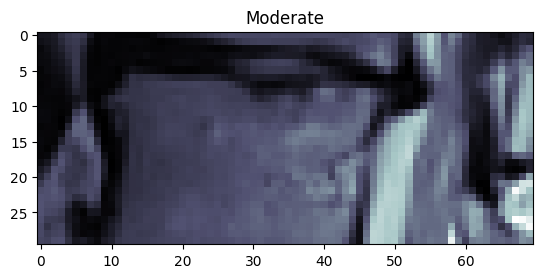

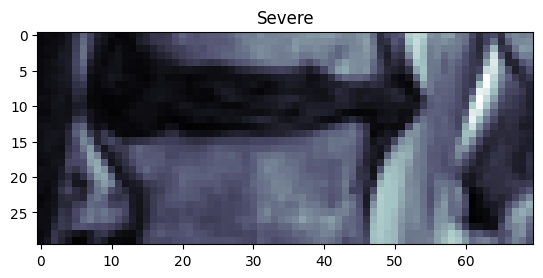

In [27]:
load_crop(train_df.iloc[0], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[350], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[185], plot=True, title='Severe', output=False)

### L2/L3 crops

In [28]:
train_df[train_df.level_code == 2].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,/home/jupyter/data/train_images/4003253/702807...,2,0
51,29931867,Spinal Canal Stenosis,L2/L3,Moderate,1676821058,12,202.628571,187.028571,Sagittal T2/STIR,/home/jupyter/data/train_images/29931867/16768...,2,1
86,52397721,Spinal Canal Stenosis,L2/L3,Severe,2452297573,9,248.645314,168.785794,Sagittal T2/STIR,/home/jupyter/data/train_images/52397721/24522...,2,2


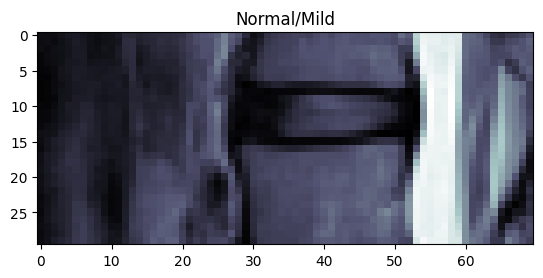

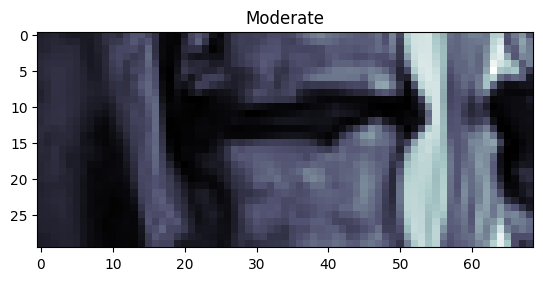

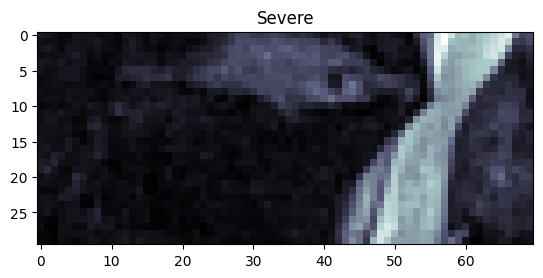

In [29]:
load_crop(train_df.iloc[1], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[51], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[86], plot=True, title='Severe', output=False)

### L5/S1 crops

In [30]:
train_df[train_df.level_code == 5].groupby('severity').head(n=1)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,image_path,level_code,severity_code
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,/home/jupyter/data/train_images/4003253/702807...,5,0
496,305152236,Spinal Canal Stenosis,L5/S1,Moderate,2421706412,12,389.753093,399.937402,Sagittal T2/STIR,/home/jupyter/data/train_images/305152236/2421...,5,1
1508,953639220,Spinal Canal Stenosis,L5/S1,Severe,270540558,12,270.775510,339.591837,Sagittal T2/STIR,/home/jupyter/data/train_images/953639220/2705...,5,2


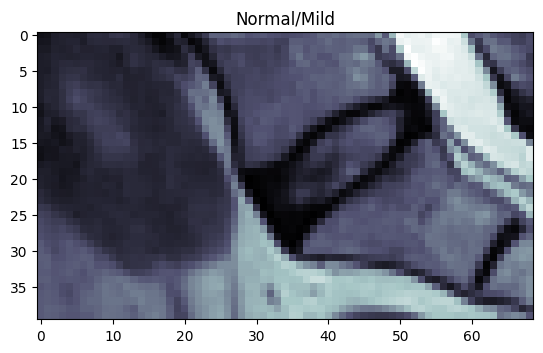

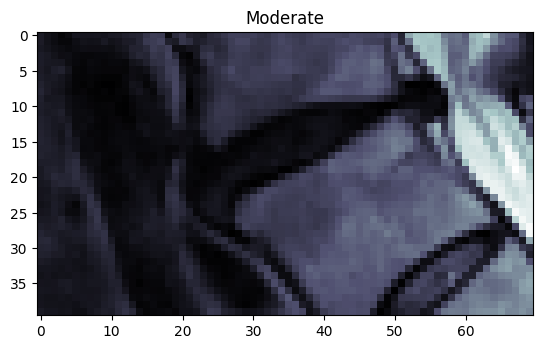

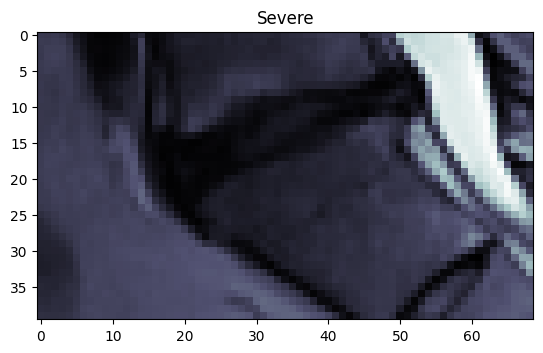

In [31]:
load_crop(train_df.iloc[4], plot=True, title='Normal/Mild', output=False)
load_crop(train_df.iloc[496], plot=True, title='Moderate', output=False)
load_crop(train_df.iloc[1955], plot=True, title='Severe', output=False)